In [ ]:
!pip install nmslib

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install libpecos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
import numpy as np

import scipy
from scipy.sparse import hstack
import pandas as pd
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import re

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

In [6]:
from pecos.utils import smat_util

In [7]:
from sentence_transformers import models, losses, SentenceTransformer

In [8]:
import nmslib

### Bert vectorizer class

In [9]:
class BertVectorizer:

    def __init__(self, model_name, device=None, batch_size=4):
        # Load pre-trained model tokenizer (vocabulary-multilingual)
        self.model = SentenceTransformer(model_name, 
                                         device=device)
        
        self.device = device
        self.batch_size = batch_size

    @property
    def max_seq_length(self):
        return self.model.max_seq_length

    def fit(self):
        pass

    def transform(self, sentences):
        sentences_vectors = self.model.encode(sentences,
                                              batch_size=self.batch_size, 
                                              normalize_embeddings=True,
                                              show_progress_bar=True,
                                              device=self.device)

        return sentences_vectors

In [10]:
# Test bert vectorizer
bert_vect = BertVectorizer(model_name='dmis-lab/biobert-v1.1')
X = ['ab, abb ab!!... ba baba aba aba abab! bab bab',
     'ab ab, abab ab, ab: abab ba baba baba ab aba. bab aba',
     'a a bab ab abab ab ab abab, ab ab ab ab abab ab aba b',
     'ab, ab ab ab, ab ab ab ba bab ab a, bab ab! ab ab ab a ba']
bert_vect.transform(X)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([[ 0.01524611, -0.01386539, -0.0005056 , ...,  0.02431792,
        -0.00521419, -0.04066012],
       [ 0.01007109, -0.01628747, -0.01875976, ...,  0.01677616,
        -0.00439986, -0.04512952],
       [-0.00527585, -0.00313786, -0.03618314, ...,  0.01396487,
         0.01128567, -0.06561056],
       [-0.01301737,  0.00134562, -0.02991924, ...,  0.02124193,
         0.00313554, -0.06946915]], dtype=float32)

### Similarity ranking model with ANN 

In [11]:
class SimilarityRankANN:
    def __init__(self, papers_vectors):

        self.papers_num = papers_vectors.shape[0]

        # mslib index creating
        self.index = index = nmslib.init(method='hnsw', space='l2')
        self.index.addDataPointBatch(papers_vectors)
        self.index.createIndex({'post': 2}, print_progress=True)

    def predict(self, questions_vectors, topk=10, return_full_vector=False):
        
        result = []

        for question_vector in tqdm(questions_vectors):

            # Get topk closest results
            papers_ids, paper_distances = self.index.knnQuery(question_vector, topk)
            # distance -> similarity score
            # Vectors are normalized, so 0 <= distance <= 1
            papers_similarity = 1 - np.array(paper_distances)

            if return_full_vector:
                question_result = np.zeros(self.papers_num)
                question_result[papers_ids] = papers_similarity
                result.append(question_result)
            else:
                result.append((papers_ids, papers_similarity))

        # Convert to sparse matrix for pecos metrics evaluation
        if return_full_vector:
            csr_matrix = scipy.sparse.csr_matrix(result, dtype=np.float32)
            return csr_matrix
        
        return result

### Load dataset

In [12]:
if 'google.colab' in sys.modules:
    df = pd.read_csv('/content/drive/MyDrive/qa_ncbi_dataset.tsv', sep='\t') # colab
else:
    df = pd.read_csv('data/qa_ncbi_dataset.tsv', sep='\t') # local run
df.shape

(29319, 15)

### Split into dataframes

In [13]:
# Paper DF # Z
papers_df = df[['snippet_url', 'title', 'abstract']] \
    .drop_duplicates() \
    .reset_index(drop=True).reset_index() \
    .rename(columns={'index': 'paper_id'})
papers_df['title_abstract'] = papers_df['title'] + '. ' + papers_df['abstract']

df = df.merge(papers_df[['paper_id', 'snippet_url']])
papers_df = papers_df.set_index('paper_id')

# # Create paper id from url
# df['paper_id'] = df.snippet_id.str.split('_')
# df['paper_id'] = df['paper_id'].apply(lambda a: a[0]).astype(int)
papers_df.sample()

,snippet_url,title,abstract,title_abstract
paper_id,,,,
20753,http://www.ncbi.nlm.nih.gov/pubmed/18948196,Viral and cellular MARCH ubiquitin ligases and...,Covalent conjugation of proteins with ubiquiti...,Viral and cellular MARCH ubiquitin ligases and...


In [14]:
# question-paper matrix # Y
question_paper_df = pd.crosstab(df['question_id'], df['paper_id']).astype(int)
question_paper_df = question_paper_df[sorted(question_paper_df.columns)]
question_paper_df.sample()

paper_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,27764,27765,27766,27767,27768,27769,27770,27771,27772,27773,27774,27775,27776,27777,27778,27779,27780,27781,27782,27783,27784,27785,27786,27787,27788,27789,27790,27791,27792,27793,27794,27795,27796,27797,27798,27799,27800,27801,27802,27803
question_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5710a51bcf1c325851000029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Question df # X
questions_df = df[['question_id', 'question_text']] \
    .drop_duplicates('question_id') \
    .set_index('question_id').loc[question_paper_df.index]
questions_df.sample()

,question_text
question_id,
601cb2e41cb411341a000023,Dasatinib and Blinatumomab are used for treatm...


### Train-test splitting

In [16]:
train_question_ids, valid_question_ids = train_test_split(questions_df.index, 
                                                          test_size=0.1,
                                                          random_state=5)
print(f'Train: {len(train_question_ids)}')
print(f'Valid: {len(valid_question_ids)}')

Train: 3636
Valid: 404


In [17]:
# Questions splitting
train_questions_df = questions_df.loc[train_question_ids]
valid_questions_df = questions_df.loc[valid_question_ids]

# Question-Paper matrix splitting
train_question_paper_df = question_paper_df.loc[train_question_ids]
train_question_paper_csr = scipy.sparse.csr_matrix(train_question_paper_df.values, dtype=np.float32)
valid_question_paper_df = question_paper_df.loc[valid_question_ids]
valid_question_paper_csr = scipy.sparse.csr_matrix(valid_question_paper_df.values, dtype=np.float32)

### Bert vectorization

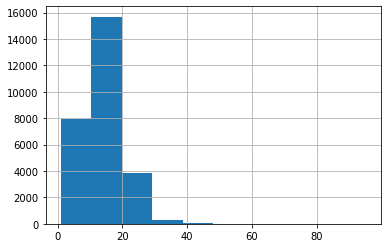

In [18]:
papers_df['title'].str.split('\W+').apply(len).hist()

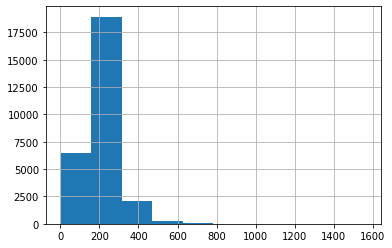

In [19]:
# The majority of abstracts fill into bert memory without truncation
papers_df['abstract'].str.split('\W+').apply(len).hist()

In [20]:
paper_column = 'title' # title_abstract / title / abstract
bert_model_name = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
# bert_model_name = 'dmis-lab/biobert-v1.1'
vectorizer = BertVectorizer(model_name=bert_model_name, 
                            device='cuda',
                            batch_size=4)
print(f'Max sentence size: {vectorizer.max_seq_length}')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Max sentence size: 512


In [87]:
train_questions = vectorizer.transform(train_questions_df.question_text.values)
valid_questions = vectorizer.transform(valid_questions_df.question_text.values)
papers = vectorizer.transform(papers_df[paper_column].values)

Batches:   0%|          | 0/909 [00:00<?, ?it/s]

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

Batches:   0%|          | 0/6951 [00:00<?, ?it/s]

### Fitting

In [93]:
model = SimilarityRankANN(papers_vectors=papers)

### Validation

In [94]:
# predicted_question_paper_csr = model.predict_multiprocess(valid_questions)

predicted_question_paper_csr = model.predict(valid_questions, topk=10, return_full_vector=True)

100%|██████████| 404/404 [00:00<00:00, 2757.34it/s]


In [ ]:
model.predict([valid_questions[0]], topk=10, return_full_vector=False)

In [95]:
metric = smat_util.Metrics.generate(valid_question_paper_csr, 
                                    predicted_question_paper_csr, 
                                    topk=10)
print(metric)

prec   = 17.08 15.35 13.37 11.88 11.19 10.52 9.51 8.94 8.44 8.07
recall = 5.99 8.25 9.39 10.25 11.93 12.86 13.42 14.24 14.60 15.03


### Checking

In [60]:
def get_papers_by_text(text, 
                       vectorizer,
                       number_of_papers=10, 
                       check_correctness=False):
  
    vector_text = vectorizer.transform([text])

    papers_ids, papers_similarities = model.predict(
        vector_text,
        topk=number_of_papers,
        return_full_vector=False)[0]

    # print()
    # print('Found papers: ', len(paper_labels))
    # print(paper_labels)

    result = papers_df.loc[papers_ids, ['title', 'abstract', 'snippet_url']]

    # For nmslib score is not probability! 
    # It similarity_i=1-distance_i/distances.sum(), 
    # introduced just to save the order
    # result['score'] = papers_similarities

    if check_correctness:
        correct_papers = df.loc[df.question_text == text, 'paper_id'].unique()
        print(f'\nTrue number of papers: {len(correct_papers)}')
        result['correctness'] = result.index.isin(correct_papers)
        print(f'Found: {result.correctness.sum()}')

    return result

In [51]:
correct_examples = [
    'Which genome browser database for DNA shape annotations is available?',
    'Has strimvelis been approved by the European Medicines Agency?',
    'What is the target of Volanesorsen?',
    'Is eptinezumab a small molecule?'
]

interesting_examples = [
    'For which type of diabetes can empagliflozin be used?',
    "Is Semagacestat effective for Alzheimer's Disease?",
    'Which gene is associated with Muenke syndrome?'     
]

In [62]:
get_papers_by_text('For which type of diabetes can empagliflozin be used?',
                   vectorizer=vectorizer, 
                   number_of_papers=10,
                   check_correctness=True)

100%|██████████| 1/1 [00:00<00:00, 1668.38it/s]


True number of papers: 17
Found: 0


,title,abstract,snippet_url,correctness
paper_id,,,,
23026,Dapagliflozin--do we need it registered for ty...,Introduction: Inhibitors of...,http://www.ncbi.nlm.nih.gov/pubmed/24998153,False
19265,Which drug to be used in smoking cessation?,There are 3 first-line medications for smoking...,http://www.ncbi.nlm.nih.gov/pubmed/18619194,False
24338,Ziconotide: can we use it in palliative care?,Ziconotide (PRIALT) is a new nonopioid treatme...,http://www.ncbi.nlm.nih.gov/pubmed/16225359,False
8421,Is HbA1c an ideal biomarker of well-controlled...,HbA1c is a biomarker with a central role in th...,http://www.ncbi.nlm.nih.gov/pubmed/32913038,False
3255,SGLT2 inhibitors: are they safe?,Sodium-glucose linked transporter type 2 (SGLT...,http://www.ncbi.nlm.nih.gov/pubmed/29039237,False
9627,Should methotrexate be used to treat early rhe...,A number of studies show the efficacy of metho...,http://www.ncbi.nlm.nih.gov/pubmed/7939730,False
17437,What is a preferred angiotensin II receptor bl...,Hypertension has a major associated risk for o...,http://www.ncbi.nlm.nih.gov/pubmed/22490507,False
278,Can the anticoagulant effects of dabigatran be...,Idarucizumab is a humanized monoclonal antibod...,http://www.ncbi.nlm.nih.gov/pubmed/27575900,False
21123,How do prescribing doctors anticipate the effe...,Objectives: Statins are a l...,http://www.ncbi.nlm.nih.gov/pubmed/20545813,False


In [99]:
# Random example
temp = valid_questions_df.question_text.sample().values[0]
print(temp)

get_papers_by_text(temp,
                   vectorizer=vectorizer,
                   number_of_papers=10,
                   check_correctness=True)

List Kartagener Syndrome Triad.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 808.46it/s]


True number of papers: 17
Found: 2


,title,abstract,snippet_url,correctness
paper_id,,,,
20737,Psychogenic Purpura (Gardner-Diamond Syndrome),"Psychogenic purpura, also known as Gardner-Dia...",http://www.ncbi.nlm.nih.gov/pubmed/26137346,False
26150,Kartagener syndrome,"Kartagener syndrome (KS), an autosomal recessi...",http://www.ncbi.nlm.nih.gov/pubmed/16940490,True
20543,[Melkersson-Rosenthal syndrome],The Melkersson-Rosenthal syndrome consists of ...,http://www.ncbi.nlm.nih.gov/pubmed/10481507,False
4090,Dyke davidoff masson syndrome. A case report,We describe a case of hemitrophy in a 12-year-...,http://www.ncbi.nlm.nih.gov/pubmed/24257011,False
3084,[Heerfordt syndrome],The Heerfordt syndrome is characterized by fev...,http://www.ncbi.nlm.nih.gov/pubmed/12233082,False
26411,[The Zivert-Kartagener syndrome in children],A comprehensive clinicomorphological examinati...,http://www.ncbi.nlm.nih.gov/pubmed/8290523,True
18606,Septo-optic dysplasia (de Morsier syndrome),A 12-year-old boy presented with poor vision a...,http://www.ncbi.nlm.nih.gov/pubmed/18018427,False
3756,[Paroxysmal finger hematoma (Achenbach syndrome)],Paroxysmal haematoma of the fingers (Achenbach...,http://www.ncbi.nlm.nih.gov/pubmed/2373612,False
317,[Crow-Fukase syndrome],"The association of polyneuropathy, organomegal...",http://www.ncbi.nlm.nih.gov/pubmed/7699917,False
